# 0. Introduction

 This idea was explored in detail with the help of a stunning experiment by Hubel and Wiesel in 1962, in which they showed that individual brain nerve cells responded (or were activated) only upon visual perception of the boundaries of a particular orientation. For example, some neurons fired when they perceived vertical boundaries, and some did upon horizontal or diagonal ones. Hubel and Wiesel found that all of these neurons are concentrated in a core architecture and together form visual perception. This idea of ​​specialized components within a system that solve specific problems (like cells in the visual cortex that look for specific characteristics) is used in machine learning, are is the basis of the [CNN](https://en.wikipedia.org/wiki/Convolutional_neural_network).

> Indented block



 Recommended video: [Visual Cortex Cell Recording](https://www.youtube.com/watch?v=Cw5PKV9Rj3o)

---

Assume you have a dataset with 200 samples (rows of data) and you choose a batch size of 5 and 1,000 epochs.

This means that the dataset will be divided into 40 batches, each with five samples. The model weights will be updated after each batch of five samples.

This also means that one epoch will involve 40 batches or 40 updates to the model.

With 1,000 epochs, the model will be exposed to or pass through the whole dataset 1,000 times. That is a total of 40,000 batches during the entire training process.

```python
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
```

* 16: This is the number of filters (also known as kernels) in the convolutional layer. These filters are responsible for extracting various features from the input image.
* (3, 3): This is the size of each filter. In this case, the filters are 3x3 in size.
* 1: This is the stride of the convolution operation, which controls how the filter slides over the input image.
* activation='relu': The ReLU (Rectified Linear Unit) activation function is applied to the output of this layer.
* input_shape=(256, 256, 3): This specifies the input shape of the first layer. It indicates that the input images are 256 pixels in height, 256 pixels in width, and have 3 color channels (RGB).


```python
model.add(Flatten())
```
This line adds a flattening layer. The purpose of this layer is to convert the 2D feature maps produced by the convolutional layers into a 1D vector, which can be used as input to a fully connected (Dense) layer.




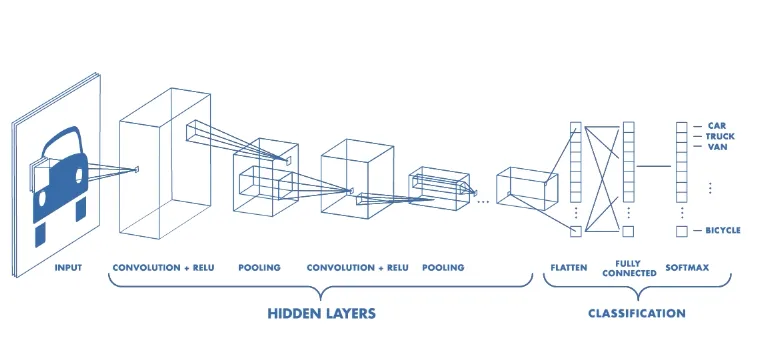

The pooling layer replaces the output of the network at certain locations by deriving a summary statistic of the nearby outputs. This helps in reducing the spatial size of the representation.

The most popular pooling function is max pooling, which reports the maximum output from the neighborhood.

# 1. Install Dependencies and Setup

In [1]:
!pip install visualkeras
!pip install tensorflow
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 5.6 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import visualkeras

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Loading Dataset

In [5]:
import numpy as np
from matplotlib import pyplot as plt

In [6]:
# !gdown 13kJTU8rxytr-6YuVcPsPzTpNsNFwz7Zq -O data/structures.zip
# !unzip data/structures.zip -d data/structures

In [7]:
from google.colab import files

# upload your kaggle credentials
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d dumitrux/architectural-styles-dataset
!mkdir data
!unzip architectural-styles-dataset -d data/styles

Streaming output truncated to the last 5000 lines.
  inflating: data/styles/g-images-dataset/Achaemenid architecture/000553.jpg  
  inflating: data/styles/g-images-dataset/Achaemenid architecture/000554.jpg  
  inflating: data/styles/g-images-dataset/Achaemenid architecture/000555.jpg  
  inflating: data/styles/g-images-dataset/American Foursquare architecture/000968.jpg  
  inflating: data/styles/g-images-dataset/American Foursquare architecture/000970.jpg  
  inflating: data/styles/g-images-dataset/American Foursquare architecture/000973.jpg  
  inflating: data/styles/g-images-dataset/American Foursquare architecture/000975.jpg  
  inflating: data/styles/g-images-dataset/American Foursquare architecture/000976.jpg  
  inflating: data/styles/g-images-dataset/American Foursquare architecture/000977.jpg  
  inflating: data/styles/g-images-dataset/American Foursquare architecture/000978.jpg  
  inflating: data/styles/g-images-dataset/American Foursquare architecture/000979.jpg  
  inflat

In [8]:
data_dir = "/content/data/styles/architectural-styles-dataset"
img_height, img_width = 256, 256
batch_size = 32
seed = 123

train_ds = tf.keras.utils.image_dataset_from_directory (
  data_dir,
  labels="inferred",
  #label_mode="categorical",
  color_mode="rgb",
  batch_size=batch_size,
  image_size=(img_height, img_width),
  shuffle=True,
  seed=seed,
  validation_split=0.2,
  subset="training",
)

val_ds = tf.keras.utils.image_dataset_from_directory (
  data_dir,
  labels="inferred",
  #label_mode="categorical",
  color_mode="rgb",
  batch_size=batch_size,
  image_size=(img_height, img_width),
  shuffle=True,
  seed=seed,
  validation_split=0.2,
  subset="validation",
)

Found 10113 files belonging to 25 classes.
Using 8091 files for training.
Found 10113 files belonging to 25 classes.
Using 2022 files for validation.


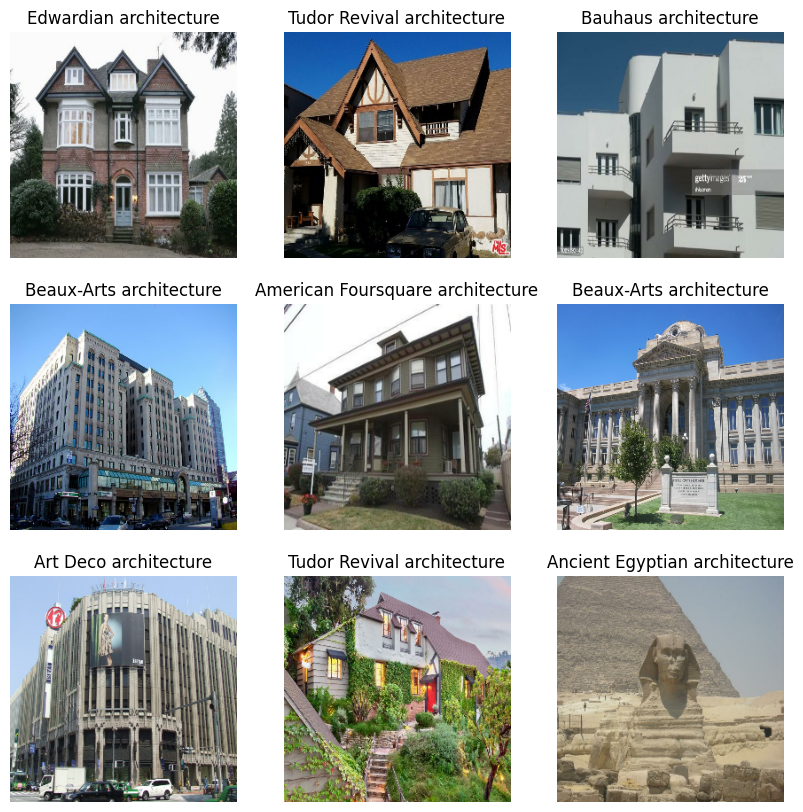

In [9]:
# Keep the number of classes for for the softmax activation
num_classes = len(train_ds.class_names)
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [10]:
def visualize_dataset(dataset):
  class_names = dataset.class_names
  num_images_per_class = [0] * len(class_names)

  for images, labels in dataset:
      for label in labels:
          num_images_per_class[label] += 1

  # Create a bar plot showing the number of images per class
  plt.figure(figsize=(10, 6))
  plt.bar(class_names, num_images_per_class, color='skyblue')
  plt.xlabel('Classes')
  plt.ylabel('Number of Images')
  plt.title('Number of Images per Class')
  plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  plt.tight_layout()
  plt.show()

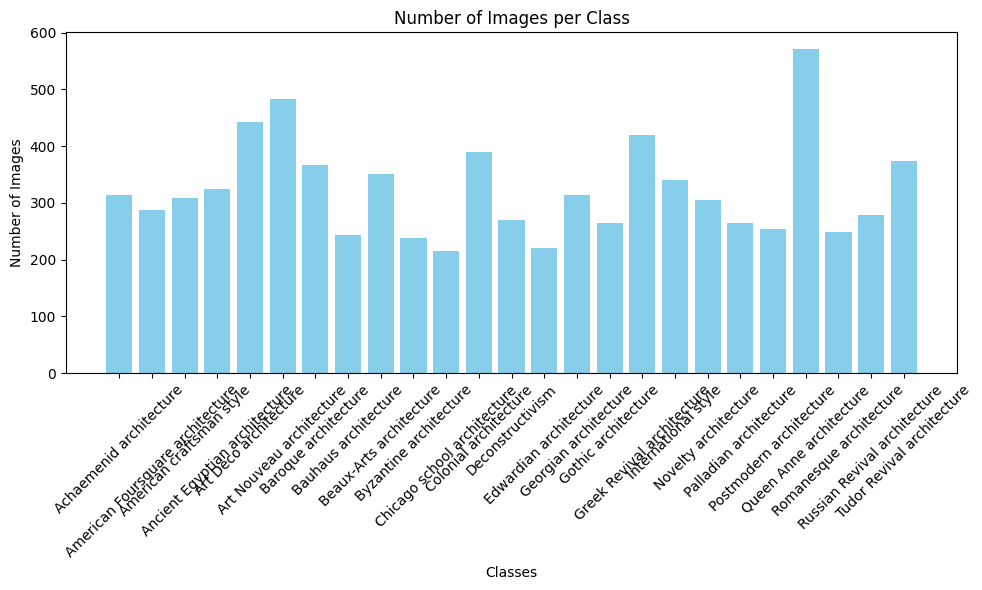

In [11]:
visualize_dataset(train_ds)

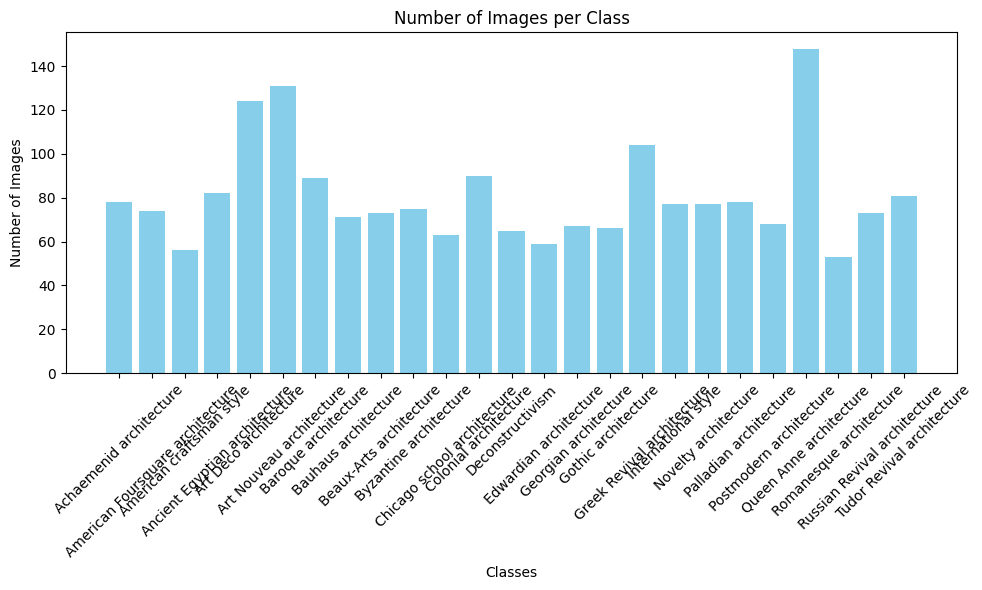

In [12]:
visualize_dataset(val_ds)

# 3. Data Preprocessing (Normalization & Augmentation)

In [13]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# Standardizes pixel values to the [0, 1] range
rescale = tf.keras.Sequential([
  layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height,img_width, 3)),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.1),
])

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  # ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

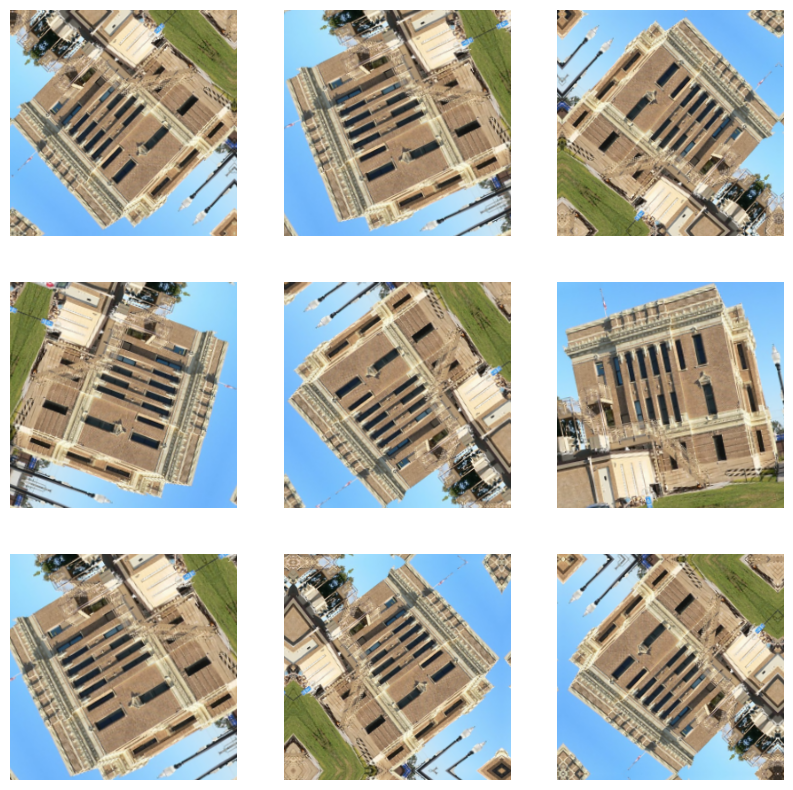

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)

In [16]:
# Configure the dataset for performance
# https://www.tensorflow.org/tutorials/images/classification#configure_the_dataset_for_performance

#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 4. Build and Train the Deep Learning Model

In [17]:
# Define the CNN model
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Output layer with classes
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              #loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)       

In [18]:
#visualkeras.layered_view(model, to_file='cnn_architecture.png', legend=True, scale_xy=1, scale_z=1, max_z=100)

In [ ]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

epochs = 10  # You can increase this based on the model's performance
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/10
253/253 [==============================] - 147s 424ms/step - loss: 3.1487 - accuracy: 0.0716 - val_loss: 2.9806 - val_accuracy: 0.1266
Epoch 2/10
253/253 [==============================] - 132s 408ms/step - loss: 2.9418 - accuracy: 0.1329 - val_loss: 3.1022 - val_accuracy: 0.1093
Epoch 3/10


# 6. Plot Performance

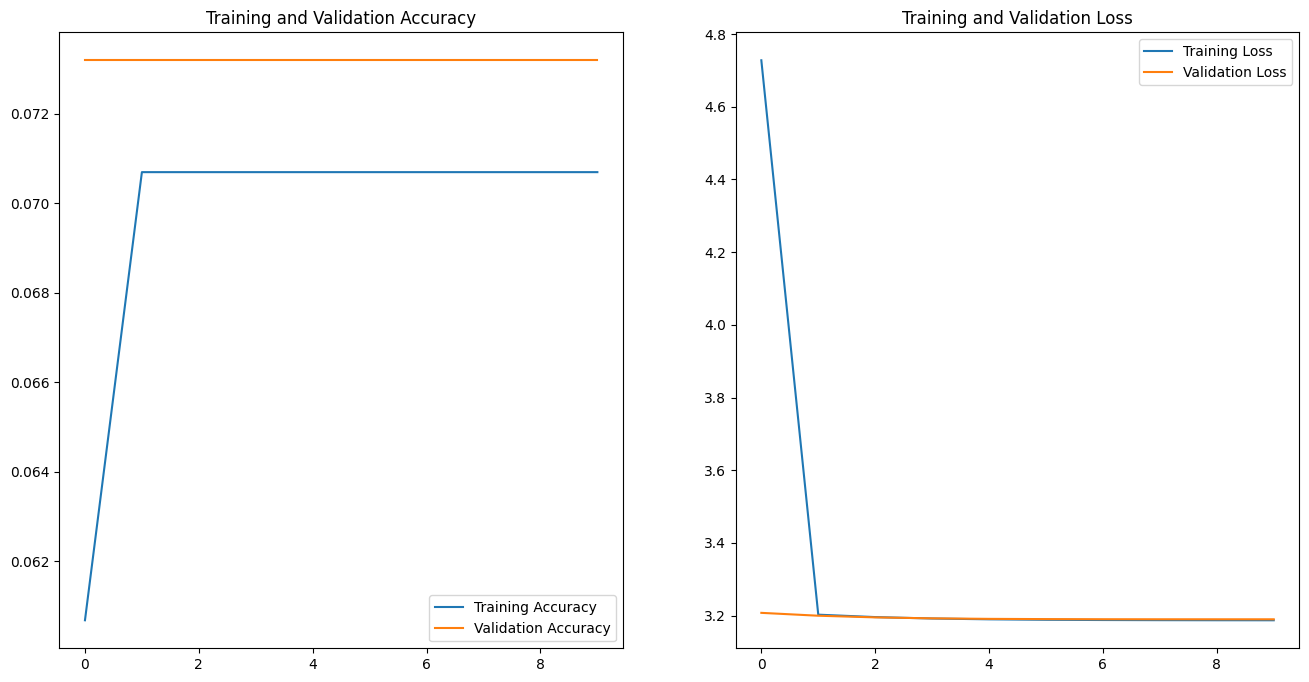

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(num_classes))

NameError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels from validation dataset
true_labels = []
for _, labels in val_ds:
    true_labels.extend(labels.numpy())

# Make predictions using the validation dataset
predicted_probs = model.predict(val_ds)
predicted_labels = np.argmax(predicted_probs, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Define class names if available (replace with your actual class names)
class_names = sorted([dir_name for dir_name in os.listdir(data_dir)
                      if os.path.isdir(os.path.join(data_dir, dir_name))])

plt.figure(figsize=(20, 16))  # Adjust the figsize as needed
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=16)  # Adjust the title fontsize if needed
plt.xlabel('Predicted Label', fontsize=14)  # Adjust the xlabel fontsize if needed
plt.ylabel('True Label', fontsize=14)  # Adjust the ylabel fontsize if needed
plt.xticks(fontsize=12)  # Adjust the xticks fontsize if needed
plt.yticks(fontsize=12)  # Adjust the yticks fontsize if needed
plt.show()

# 7. Predict on new data

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

# 8. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

model_dir = os.path.join('models','arch_classifier.h5')

In [ ]:
model.save(model_dir)

In [ ]:
# model = load_model(os.path.join('models','arch_classifier.h5'))

# 9. K-means Clustering

In [ ]:
def extract_features(feature_extractor, data):
  return feature_extractor.predict(data)

In [ ]:
# remove the augmentation layer
feature_extractor = Sequential(model.layers[1:-1])

train_features = extract_features(feature_extractor, train_ds)
val_features = extract_features(feature_extractor, val_ds)

features = np.concatenate((train_features, val_features))
# features = np.array(train_features + val_features)

In [ ]:
train_labels = np.concatenate([y for x, y in train_ds], axis=0)
val_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Concatenate the labels
labels = np.concatenate([train_labels, val_labels], axis=0)

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
reduced_features_pca = pca.fit_transform(features)

In [ ]:
from sklearn.cluster import KMeans

# Apply k-means clustering
num_clusters = num_classes # FIND A GOOD NUMBER HERE

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clustered_pca = kmeans.fit_predict(reduced_features_pca)

centroids_pca = kmeans.cluster_centers_

In [ ]:
# Plot the 2D representation with centroids
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(class_names):
    # Create a boolean array where each element is True if the corresponding label is equal to i, and False otherwise.
    cluster_points = reduced_features_pca[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=class_name)

# Plot centroids
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='x', s=200, color='black', label='Centroids')

plt.title('Visualized on PCA 2D')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='upper right')
plt.show()

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
reduced_features_tsne = tsne.fit_transform(features)

In [ ]:
# Apply k-means clustering
num_clusters = num_classes # FIND A GOOD NUMBER HERE

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clustered_tsne = kmeans.fit_predict(reduced_features_tsne)

# Transform cluster centers using the same PCA object
centroids_tsne = kmeans.cluster_centers_

In [ ]:
# Plot the 2D representation with centroids
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(class_names):
    # Create a boolean array where each element is True if the corresponding label is equal to i, and False otherwise.
    cluster_points = reduced_features_tsne[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=class_name)

# Plot centroids
plt.scatter(centroids_tsne[:, 0], centroids_tsne[:, 1], marker='x', s=200, color='black', label='Centroids')

plt.title('Visualized on TSNE 2D')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Plot the 2D representation with centroids
plt.figure(figsize=(22, 10))

plt.subplot(1, 2, 1)
plt.title('Visualized on PCA 2D')

for i, class_name in enumerate(class_names):
    cluster_points = reduced_features_pca[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=class_name)

plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='x', s=200, color='black', label='Centroids')
plt.legend(loc='upper right')


plt.subplot(1, 2, 2)
plt.title('Visualized on TSNE 2D')

for i, class_name in enumerate(class_names):
    cluster_points = reduced_features_tsne[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=class_name)

plt.scatter(centroids_tsne[:, 0], centroids_tsne[:, 1], marker='x', s=200, color='black', label='Centroids')
plt.legend(loc='upper right')

plt.suptitle('Comparing clustering result when visualized using PCA2D vs. TSNE2D')
plt.show()